# Run IDF

In [1]:
from tqdm import tqdm
from _ReIDF import run_IDF

# idf_files = ['../_base/idf/HVACDetailed-Jul.idf']
idf_files = ['ref/HVACDetailed-Jul.idf']
weather_file = '../_base/epw/ED-TMYx.2023.epw'
energyplus_exe = 'C:/EnergyPlusV23-2-0/EnergyPlus'

output_folders = []
for idf_file in tqdm(idf_files, desc="E+ running", unit=".idf file"):
    output_folder = run_IDF(idf_file, weather_file, energyplus_exe=energyplus_exe)
    output_folders.append(output_folder)

E+ running: 100%|██████████| 1/1 [07:06<00:00, 426.58s/.idf file]

Simulation completed successfully.
Output Folder: ref\HVACDetailed-Jul


# Plot HeatBalance
https://unmethours.com/question/20720/energy-plus-calculate-zone-energy-balance-manually/

# Validation
2029.477185	1790.84028	0	-20222.56028	0	16410.03146	4.99013263


In [1]:
%matplotlib inline

import pandas as pd
from _pltReIDF import load_long, compute_aggs, get_df, plot_heat_balance

# If you have zone areas, load them as:
# areas = pd.read_csv("areas.csv")  # columns: Zone, Area_m2
areas = None  # optional
eplusout_path = "../_base/idf/HVACDetailed-Jul/eplusout.csv"
long_df = load_long(eplusout_path, assume_year=2021, areas_df=areas)
aggs = compute_aggs(long_df)  # monthly/yearly, building/zonetype/zone in Wh

C:\Users\s2589602\AppData\Local\Temp\ipykernel_21256\200348644.py:72: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  reds    = cm.get_cmap("Reds",    len(gains) + 2)
C:\Users\s2589602\AppData\Local\Temp\ipykernel_21256\200348644.py:73: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  blues   = cm.get_cmap("Blues",   len(losses) + 2)
C:\Users\s2589602\AppData\Local\Temp\ipykernel_21256\200348644.py:74: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  purples = cm.get_cm

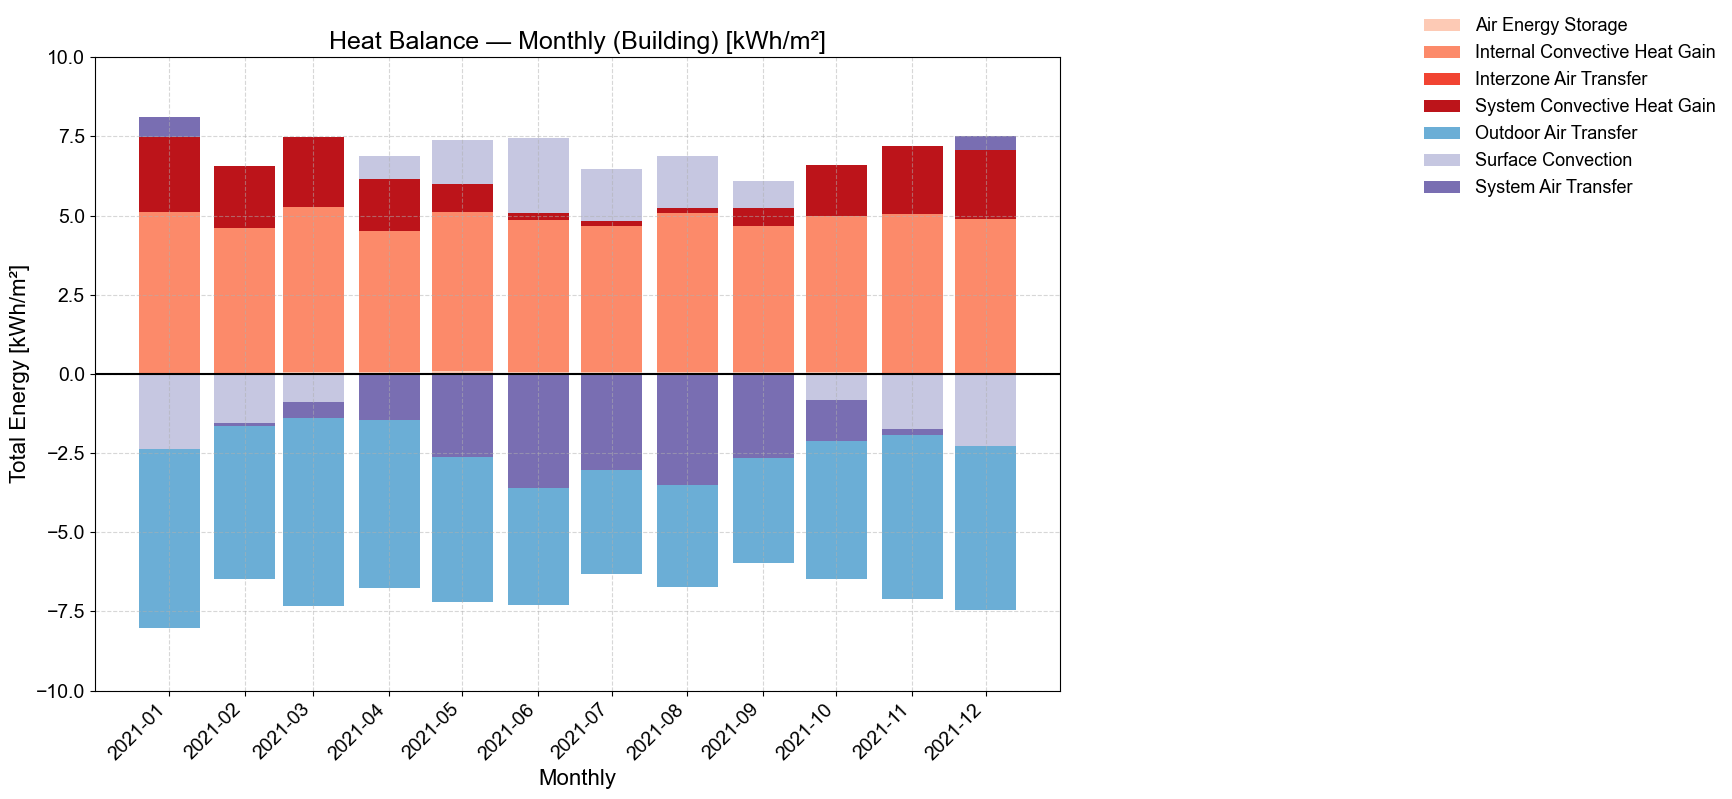

In [6]:

df_bldg_m = get_df(
    aggs, scale="monthly", scope="building",
    units="kWh", per_m2=True, total_area=8894,
    long_df_for_area=long_df
)

# Show monthly totals for first few months
df_bldg_m
plot_heat_balance(df_bldg_m, scale="monthly", scope="building",ylim_abs=10,
                  units="kWh", per_m2=True, show_net=False)

C:\Users\s2589602\AppData\Local\Temp\ipykernel_21256\2612067418.py:72: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  reds    = cm.get_cmap("Reds",    len(gains) + 2)
C:\Users\s2589602\AppData\Local\Temp\ipykernel_21256\2612067418.py:73: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  blues   = cm.get_cmap("Blues",   len(losses) + 2)
C:\Users\s2589602\AppData\Local\Temp\ipykernel_21256\2612067418.py:74: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  purples = cm.get

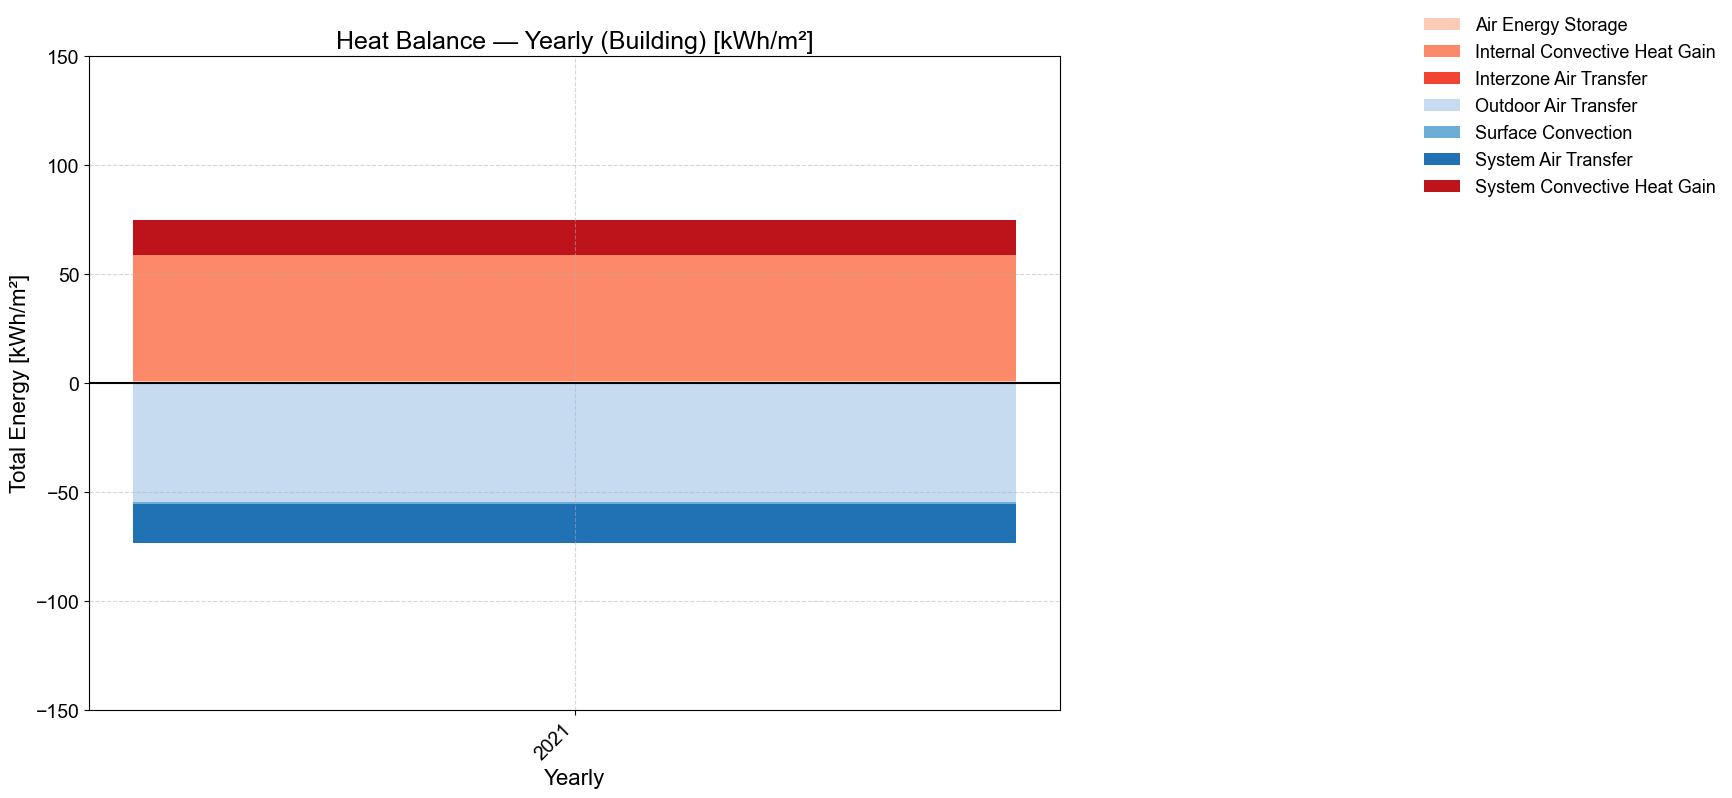

In [12]:
df_bldg_y = get_df(
    aggs, scale="yearly", scope="building",
    units="kWh", per_m2=True, total_area=8894,
    long_df_for_area=long_df
)

# Show monthly totals for first few months
df_bldg_y
plot_heat_balance(df_bldg_y, scale="yearly", scope="building",ylim_abs=150,
                  units="kWh", per_m2=True, show_net=False)

# Compare

In [7]:
import pandas as pd
from _pltReIDF import load_long, compute_aggs, get_df

# --- Load EnergyPlus outputs ---
areas = None  # or pd.read_csv("areas.csv") if available
eplusout_path = "../_base/idf/HVACDetailed-Jul/eplusout.csv"

long_df = load_long(eplusout_path, assume_year=2021, areas_df=areas)
aggs = compute_aggs(long_df)

# --- Pick a zone name ---
# (1) List some available zones to check spelling
print(sorted(long_df["Zone"].unique())[:10])

# (2) Choose one from that list, for example:
zone_name = "ZONE1-1_ATRIUM_122D7807"  # replace with an actual name in your file

# --- Get MONTHLY data for that zone ---
df_zone_m = get_df(
    aggs,
    scale="monthly",         # monthly aggregation
    scope="zone",            # single zone
    zone=zone_name,
    units="kWh",             # Wh or kWh
    per_m2=False,            # True if you have Area_m2 and want kWh/m²
    long_df_for_area=long_df # required if per_m2=True
)




['ZONE1-1_ATRIUM_122D7807', 'ZONE1-2_CAFE_C7957808', 'ZONE2-1_MEETING_10_E27BD287', 'ZONE2-1_MEETING_11_5C47B32F', 'ZONE2-1_MEETING_12_F3147A16', 'ZONE2-1_MEETING_13_688C01B5', 'ZONE2-1_MEETING_14_6570D168', 'ZONE2-1_MEETING_15_0B11BC6A', 'ZONE2-1_MEETING_16_44274E7F', 'ZONE2-1_MEETING_17_F7BC9090']


In [8]:
df_zone_m.to_csv("zone1-1_atrium_122d7807.csv")

C:\Users\s2589602\AppData\Local\Temp\ipykernel_21256\2612067418.py:72: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  reds    = cm.get_cmap("Reds",    len(gains) + 2)
C:\Users\s2589602\AppData\Local\Temp\ipykernel_21256\2612067418.py:73: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  blues   = cm.get_cmap("Blues",   len(losses) + 2)
C:\Users\s2589602\AppData\Local\Temp\ipykernel_21256\2612067418.py:74: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  purples = cm.get

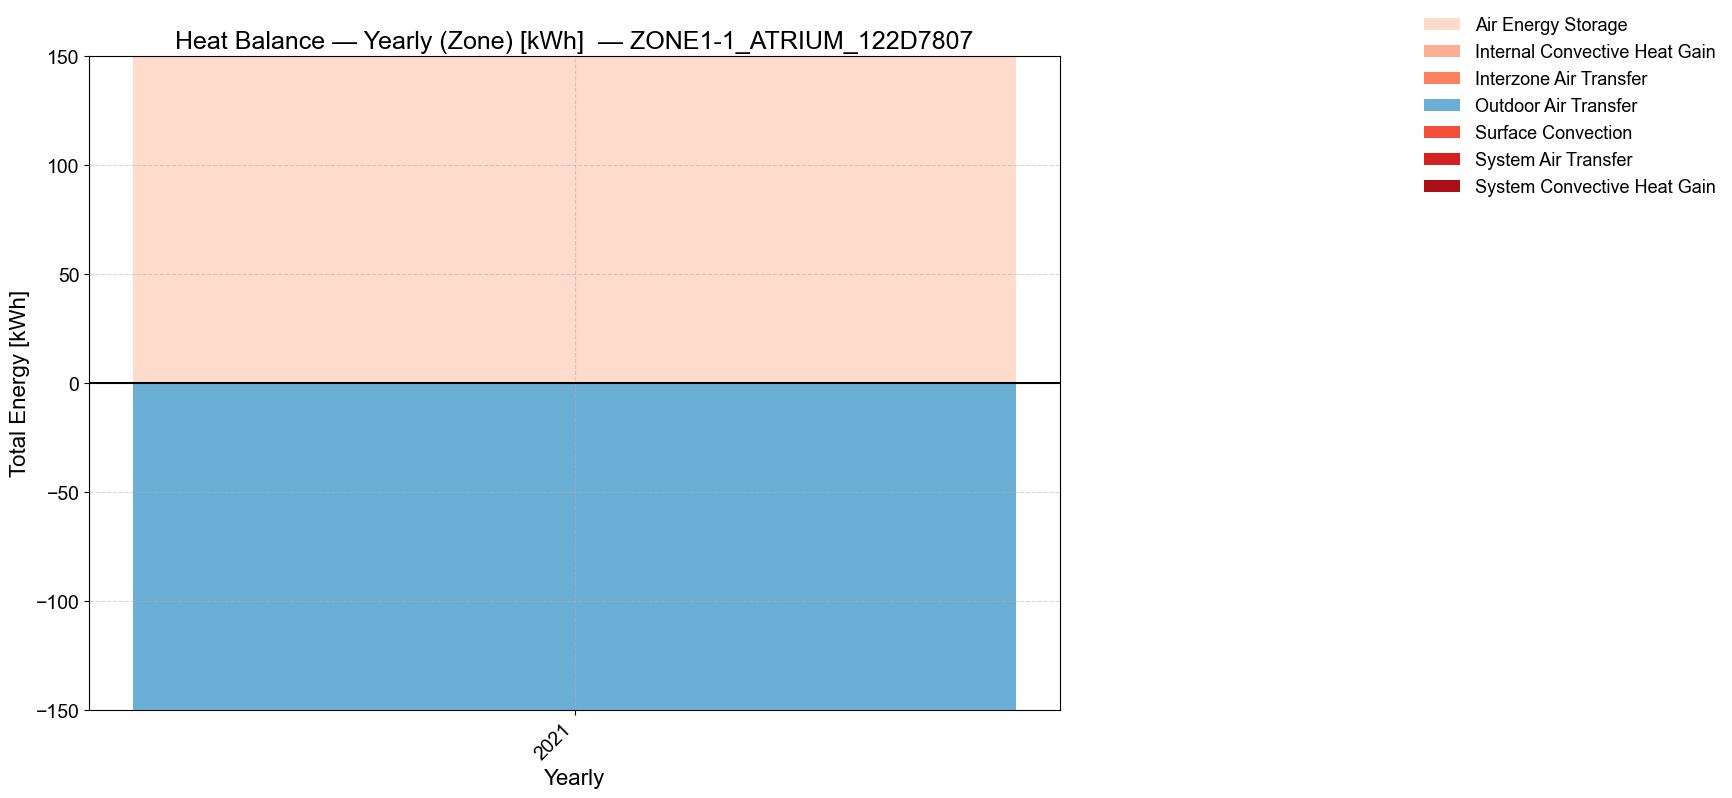

C:\Users\s2589602\AppData\Local\Temp\ipykernel_21256\2612067418.py:72: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  reds    = cm.get_cmap("Reds",    len(gains) + 2)
C:\Users\s2589602\AppData\Local\Temp\ipykernel_21256\2612067418.py:73: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  blues   = cm.get_cmap("Blues",   len(losses) + 2)
C:\Users\s2589602\AppData\Local\Temp\ipykernel_21256\2612067418.py:74: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  purples = cm.get

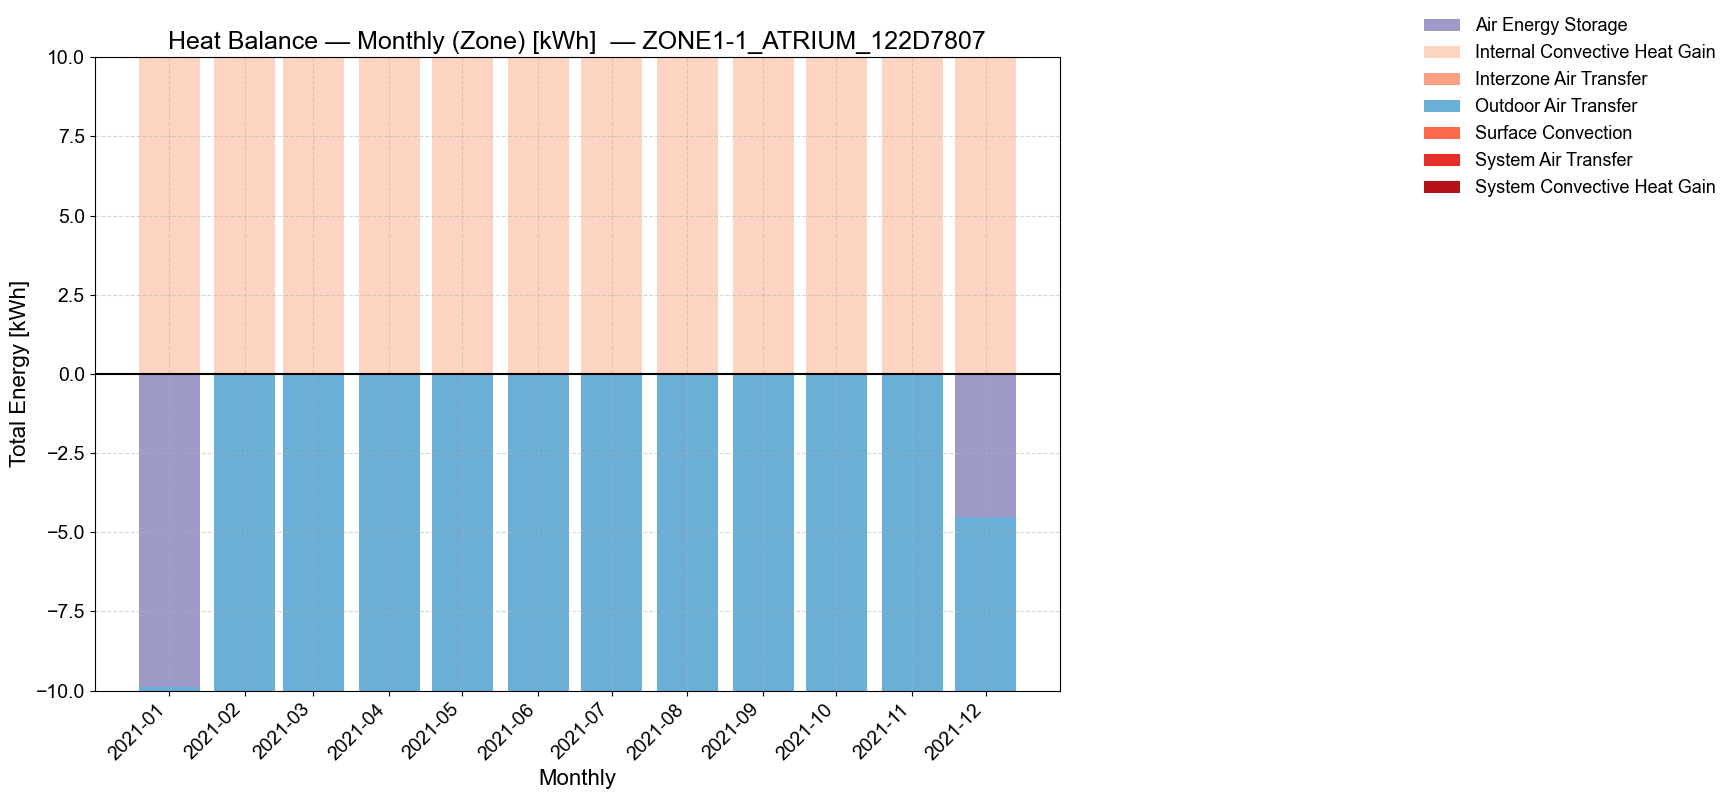

In [16]:
# Peek at available zones (optional)
sorted(long_df["Zone"].unique())[:10]
# e.g. choose one:
zone_name = "ZONE1-1_ATRIUM_122D7807"   # <-- replace with your target

# YEARLY totals for the zone (kWh/m² if you have Area_m2 in long_df)
df_zone_y = get_df(
    aggs, scale="yearly", scope="zone",
    zone=zone_name,
    units="kWh", per_m2=False,              # per-m² uses the zone’s Area_m2 from long_df (if present)
    long_df_for_area=long_df
)

# MONTHLY totals for the same zone
df_zone_m = get_df(
    aggs, scale="monthly", scope="zone",
    zone=zone_name,
    units="kWh", per_m2=False,
    long_df_for_area=long_df
)

# Plot YEARLY (symmetric ±150)
plot_heat_balance(
    df_zone_y, scale="yearly", scope="zone",
    units="kWh", per_m2=False, show_net=False,
    ylim_abs=150, title_suffix=f" — {zone_name}"
)

# Plot MONTHLY (symmetric ±10)
plot_heat_balance(
    df_zone_m, scale="monthly", scope="zone",
    units="kWh", per_m2=False, show_net=False,
    ylim_abs=10, title_suffix=f" — {zone_name}"
)
